##Omid Jafaei

##Mohammad Jawad Amin

##Mohammad Reza Baqeri

# Install libraries

In [ ]:
%%capture
!pip install gdown
!pip install transformers datasets evaluate
!pip install accelerate -U
!nvidia-smi

In [ ]:
!mkdir /content/Codes

In [ ]:
%cd /content/Codes

/content/Codes


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving utility.py to utility.py


# Import libraries

In [ ]:
from transformers import BertForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, set_seed
from transformers import DataCollatorWithPadding
import torch.nn as nn
import logging
import torch
import evaluate
import utility
import warnings
import random
import numpy as np
warnings.filterwarnings('ignore', category=UserWarning)
%load_ext autoreload
%autoreload 2

In [ ]:
Seed = 42
random.seed(Seed)
np.random.seed(Seed)
torch.manual_seed(Seed)
set_seed(Seed)

# Process on data

## Downloading and Processing Datasets

In this section, we download and process the training and development datasets.


In [ ]:
data_handler = utility.DataHandler()
data_handler.download_and_process_datasets(Download = True)


## Tokenization of Datasets

In this section, we tokenize the training and validation datasets using the BERT-based tokenizer.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
id2label = {0 :'human', 1 :'chatGPT', 2 :'cohere', 3 :'davinci', 4 :'bloomz', 5 :'dolly'}
label2id = {'human': 0, 'chatGPT': 1, 'cohere': 2, 'davinci': 3, 'bloomz': 4, 'dolly': 5}


tokenized_ds_train, tokenized_ds_val = data_handler.tokenize_datasets(tokenizer)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/71027 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

## Plot Distribution of Labels in Dataset

In this section, we visualize the distribution of labels in the training and validation datasets using a distribution plot.

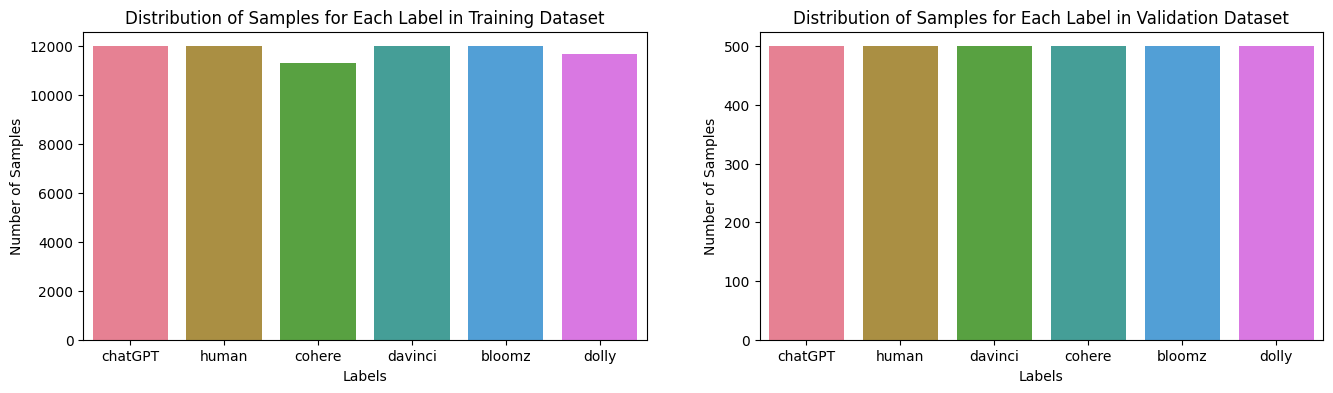


Label Counts for Training Dataset:
chatGPT: 11995
human: 11997
cohere: 11336
davinci: 11999
bloomz: 11998
dolly: 11702

Label Counts for Validation Dataset:
chatGPT: 500
human: 500
davinci: 500
cohere: 500
bloomz: 500
dolly: 500





In [ ]:
data_handler.distribution_plot(tokenized_ds_train, tokenized_ds_val, id2label, output_filename='Part_One_Dataset_distribution_plot.png')


# FineTune Bert

## Model Initialization

In this section, we initialize four different instances of the BERT-based sequence classification model with varying percentages of labeled data.

In [ ]:
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)


model_OnePercent = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label=id2label, label2id=label2id)
model_FivePercent = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label=id2label, label2id=label2id)
model_TenPercent = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label=id2label, label2id=label2id)
model_FiftyPercent = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label=id2label, label2id=label2id)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

we initialize an evaluation metric for accuracy, a data collator with padding using the specified tokenizer, and determine the available computing device.

In [ ]:
metric = evaluate.load('accuracy')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Training Model with 1% Labeled Data

In this section, we prepare and visualize 1% of the labeled training and validation data, then train the BERT-based sequence classification model (`model_OnePercent`) using this subsampled data.

In [ ]:
data_valid = tokenized_ds_val.shuffle(seed=42)

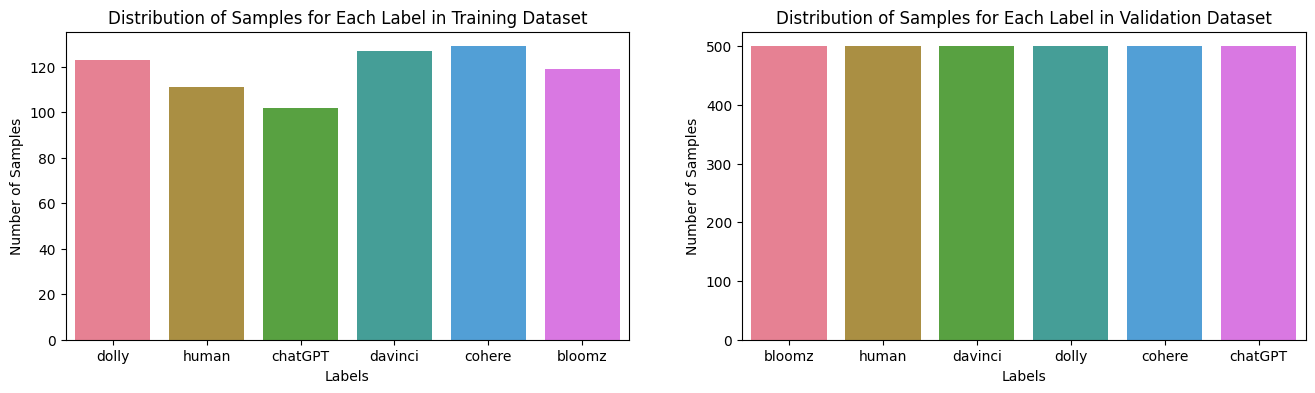


Label Counts for Training Dataset:
dolly: 123
human: 111
chatGPT: 102
davinci: 127
cohere: 129
bloomz: 119

Label Counts for Validation Dataset:
bloomz: 500
human: 500
davinci: 500
dolly: 500
cohere: 500
chatGPT: 500





You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.768525,0.196333
2,No log,1.727124,0.224333
3,No log,1.638226,0.303333
4,No log,1.665408,0.253667
5,No log,1.607514,0.293333


In [ ]:
data_train_onePrecet = tokenized_ds_train.shuffle(seed=42).shard(num_shards=100, index=0)


data_handler.distribution_plot(data_train_onePrecet, data_valid, id2label, output_filename='Part_One_Distribution_One_Percent.png')

# Train
OnePercent = utility.train_model(model=model_OnePercent,
                         train_set=data_train_onePrecet,
                         val_set=data_valid,
                         epochs=5,
                         batch_size=64,
                         tokenizer = tokenizer,
                         data_collator = data_collator,
                         metric = metric,
                         device = device,
                         seed_value = 42
                         )


## Training Model with 5% Labeled Data

In this section, we prepare and visualize 5% of the labeled training and validation data, then train the BERT-based sequence classification model (`model_FivePercent`) using this subsampled data.

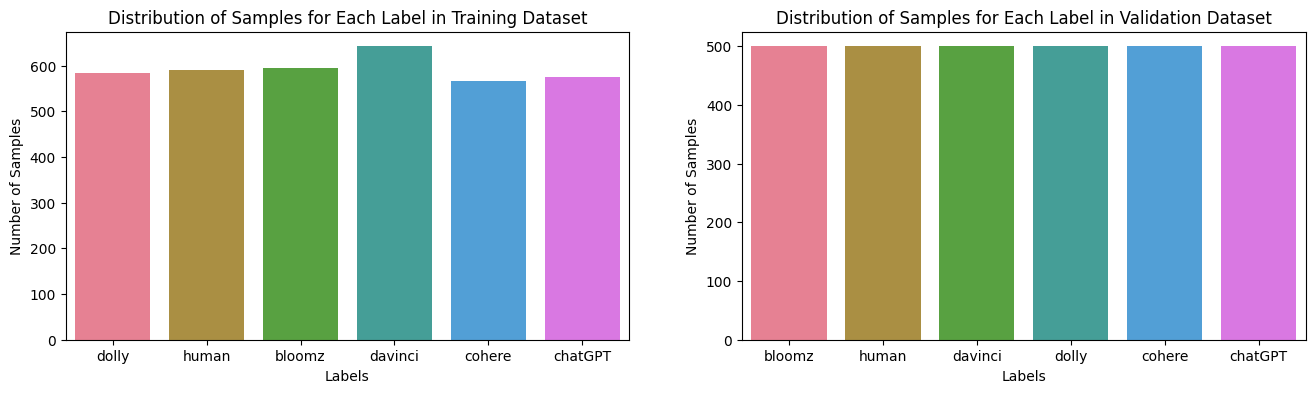


Label Counts for Training Dataset:
dolly: 583
human: 591
bloomz: 595
davinci: 642
cohere: 567
chatGPT: 574

Label Counts for Validation Dataset:
bloomz: 500
human: 500
davinci: 500
dolly: 500
cohere: 500
chatGPT: 500





Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.692757,0.249333
2,No log,1.786625,0.257000
3,No log,1.664644,0.386000
4,No log,1.757363,0.395667
5,No log,1.909875,0.378000


In [ ]:
data_train_FivePercent = tokenized_ds_train.shuffle(seed=42).shard(num_shards=20, index=0)


data_handler.distribution_plot(data_train_FivePercent, data_valid, id2label, output_filename='Part_One_Distribution_Five_Percent.png')

# Train

FivePercent = utility.train_model(model=model_FivePercent,
                         train_set=data_train_FivePercent,
                         val_set=data_valid,
                         epochs=5,
                         batch_size=64,
                         tokenizer = tokenizer,
                         data_collator = data_collator,
                         metric = metric,
                         device = device,
                         seed_value = 42
                         )

## Training Model with 10% Labeled Data

In this section, we prepare and visualize 10% of the labeled training and validation data, then train the BERT-based sequence classification model (`model_TenPercent`) using this subsampled data.

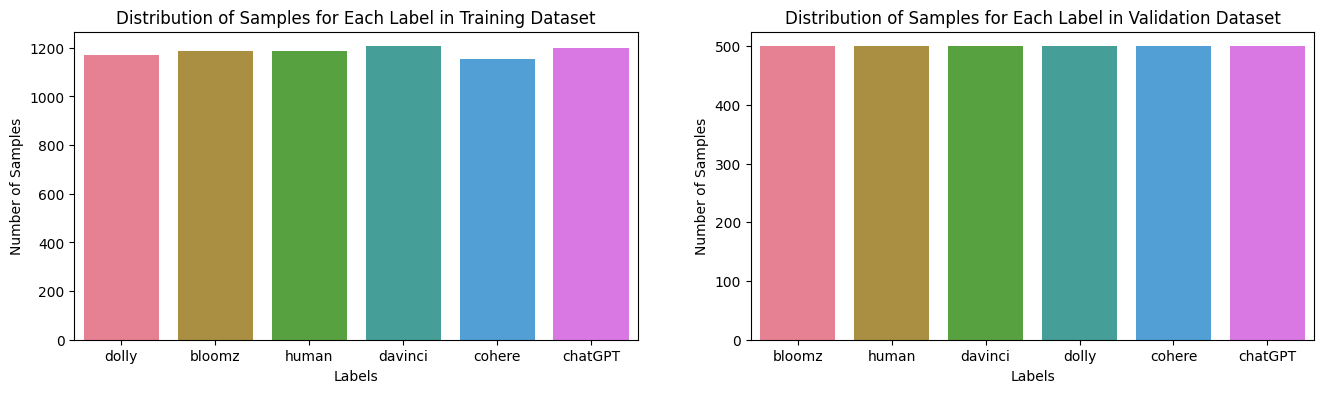


Label Counts for Training Dataset:
dolly: 1170
bloomz: 1188
human: 1187
davinci: 1206
cohere: 1154
chatGPT: 1198

Label Counts for Validation Dataset:
bloomz: 500
human: 500
davinci: 500
dolly: 500
cohere: 500
chatGPT: 500





Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.657098,0.339000
2,No log,1.747011,0.417667
3,No log,1.641158,0.495333
4,No log,1.861230,0.461000
5,No log,1.931270,0.470667


In [ ]:
data_train_TenPercent = tokenized_ds_train.shuffle(seed=42).shard(num_shards=10, index=0)


data_handler.distribution_plot(data_train_TenPercent, data_valid, id2label, output_filename='Part_One_Distribution_Ten_Percent.png')

# Train

TenPercent = utility.train_model(model=model_TenPercent,
                         train_set=data_train_TenPercent,
                         val_set=data_valid,
                         epochs=5,
                         batch_size=64,
                         tokenizer = tokenizer,
                         data_collator = data_collator,
                         metric = metric,
                         device = device,
                         seed_value = 42
                         )

## Training Model with 50% Labeled Data

In this section, we prepare and visualize 50% of the labeled training and validation data, then train the BERT-based sequence classification model (`model_FiftyPercent`) using this subsampled data.

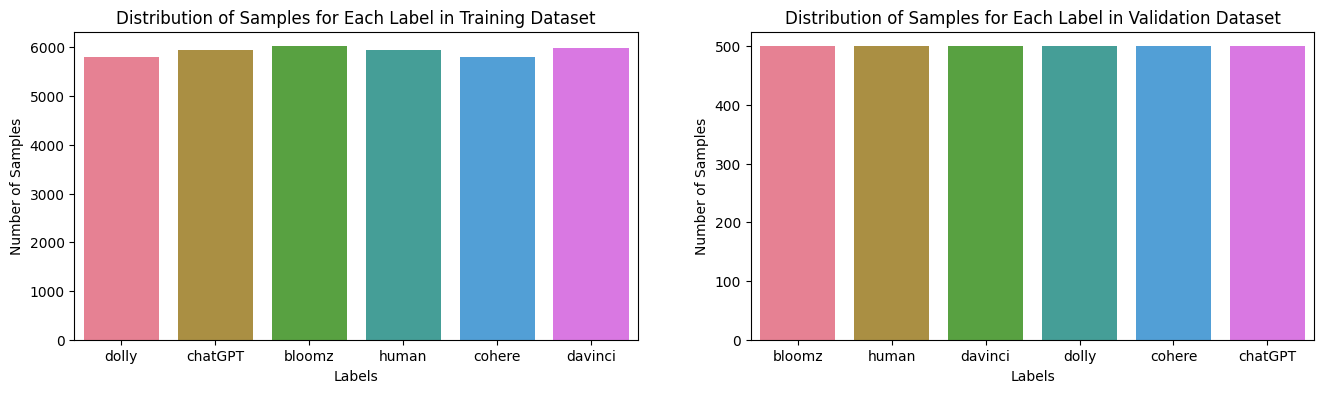


Label Counts for Training Dataset:
dolly: 5792
chatGPT: 5953
bloomz: 6020
human: 5950
cohere: 5810
davinci: 5989

Label Counts for Validation Dataset:
bloomz: 500
human: 500
davinci: 500
dolly: 500
cohere: 500
chatGPT: 500





Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.531999,0.513667
2,No log,1.670568,0.517000
3,No log,1.801726,0.522333
4,No log,2.147301,0.524333
5,No log,2.410176,0.522333


In [ ]:
data_train_FiftyPercent = tokenized_ds_train.shuffle(seed=42).shard(num_shards=2, index=0)


data_handler.distribution_plot(data_train_FiftyPercent, data_valid, id2label, output_filename='Part_One_Distribution_Fifty_Percent.png')

# Train

FiftyPercent = utility.train_model(model=model_FiftyPercent,
                         train_set=data_train_FiftyPercent,
                         val_set=data_valid,
                         epochs=5,
                         batch_size=64,
                         tokenizer = tokenizer,
                         data_collator = data_collator,
                         metric = metric,
                         device = device,
                         seed_value = 42
                         )

## Plotting Accuracy vs. Percentage of Labeled Data

In this section, we visualize the accuracy of the BERT-based sequence classification model at different percentages of labeled data.


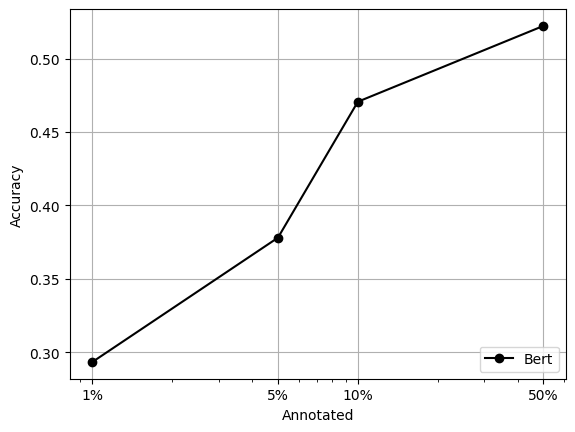

In [ ]:
percentages = [1, 5, 10, 50]
bert_accuracies = [OnePercent[-1], FivePercent[-1], TenPercent[-1], FiftyPercent[-1]]

utility.plot_accuracy_vs_percentage(percentages, bert_accuracies, label='Bert')

Saving Accuracy for Part Three:

In [ ]:
import pickle

with open('bert_accuracies.pkl', 'wb') as file:
    pickle.dump(bert_accuracies, file)